In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import mglearn
from sklearn.model_selection import train_test_split
from IPython.display import HTML, display

%matplotlib inline
display(HTML("<style>img{max-width:90% !important;}</style>"))

# 教師あり学習
機械学習を使う上で、データ自体や解決を試みている問題とデータとの関係を理解する事は重要。

* 解く問題は何か、集めたデータで求まるか
* 問題を機械学習アルゴリズムへどう当てはめるか
* データ量は十分か、抽出した特徴量で解が出るか
* 推論の正誤をどう判断するか
* 製品の他の部分と機械学習はどのように関わるのか

# データを観察する
初めにデータは検査 (機械学習を使わず解ける、データに必要な情報が無い、異常値・おかしな点が無いか) したほうが良い。検査には可視化が有効。 pd.scatter_matrix はデータの特徴量のクロス集計を散布図として描画する。

In [2]:
# アイリスの花 (複数の特徴量から花の種類を特定する)
iris_dataset = datasets.load_iris()

# 特徴量は6つ
print(iris_dataset.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [3]:
# データを訓練用とテスト用に分ける (既定ではテスト用に25%を取り分ける)
X_train, X_test, y_train, y_test = train_test_split(iris_dataset.data, iris_dataset.target, random_state=0)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (112, 4)
y_train shape: (112,)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029490CBF2E8>,
      dtype=object)

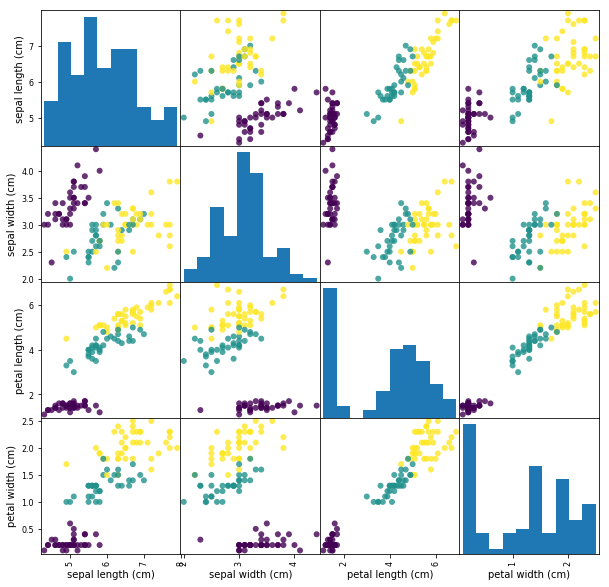

In [4]:
iris_dataframe = pd.DataFrame(X_train, columns=iris_dataset.feature_names)
pd.plotting.scatter_matrix(iris_dataframe, c=y_train, marker="o", alpha=0.8, figsize=(10, 10))

# 学習器のIF
scikit-learnは学習器がEstimatorの派生クラスとして作られており、様々なアルゴリズムを共通する操作で使用できる。

In [5]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

# 学習
knn.fit(X_train, y_train)

# 推論
pred = knn.predict([[5, 2.9, 1, 0.2]])
print(f"Prediction: {pred}")

# 評価
score = knn.score(X_test, y_test)
print(f"Test set score: {score:0.3}")

Prediction: [0]
Test set score: 0.974


# k-近傍法
先の使用した学習器はk-最近傍法と呼ぶ。学習データを丸ごと取り込み、推論時に与えられた点と最も近い点を学習データからk個取出して多数決を取る。次の学習器が使用可能。

* KNeighborsClassifier: クラス分類
* KNeighborsRegressor: 回帰

## 特徴

* メリット
    * 学習処理が早い
    * モデルの解釈がしやすい
    * あまり調整しなくても性能が良い
* デメリット
    * 訓練データが増えると推論処理に時間がかかる
    * 特徴量が多いデータセットでは上手く機能しない (疎なデータセットでは特に)

## パラメータ

* n_neighbors  
  kの値。小さい程に訓練データへは高精度になるが汎化性能は下がる。大きい程、全学習データの平均へと近づき、精度は下がる。3や5あたりで十分な事が多い

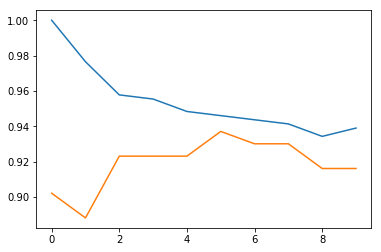

In [6]:
cancer = datasets.load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=66)

# 同時に適用不足と過剰適合 (過学習) を可視化
acc_train, acc_test = list(), list()
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    acc_train.append(knn.score(X_train, y_train))
    acc_test.append(knn.score(X_test, y_test))
    
plt.plot(acc_train)
plt.plot(acc_test)

0.8344172446249604

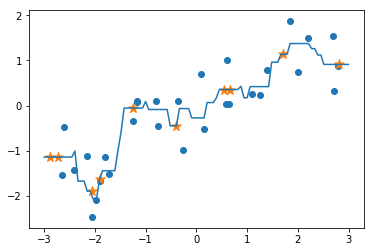

In [7]:
# 回帰としてk-最近傍法の亜種 (k-近傍回帰) を使ってみる
from sklearn.neighbors import KNeighborsRegressor

# 学習
X, y = mglearn.datasets.make_wave(40)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
plt.scatter(X_train, y_train)

# 推論
reg = KNeighborsRegressor(3).fit(X_train, y_train)
plt.scatter(X_test, reg.predict(X_test), marker="*", s=100)

line = np.linspace(-3, 3, 100).reshape(-1, 1)
plt.plot(line, reg.predict(line))

# 評価 (決定係数)
reg.score(X_test, y_test)

# 線形モデル
## 特徴

* 予測手法が理解しやすい
* 係数の値の根拠は分かりづらい (強く相関した特徴量がある場合は特に)
* 特徴量の数がサンプルの数より多いときに性能を発揮する。低次元では他のモデルの方が良い汎化性能を示すこともある

## パラメータ
線形モデルにはパラメータとして正則化というものが登場する。数値の調整は対数スケールで行うと良い。

| 学習器             | 正則化の強度 | 正則化の種類指定       | ソルバの変更 |
|--------------------|--------------|------------------------|--------------|
| LinearRegression   | -            | -                      | -            |
| Ridge              | alpha        | -                      | sag使用可    |
| Lasso              | alpha        | -                      | -            |
| LogisticRegression | C            | penalty = "l1" or "l2" | sag使用可    |
| LinearSVC          | C            | penalty = "l1" or "l2" | -            |

* alpha:  大きいほど制約が強い
* c: 小さいほど制約が強い
* penalty: デフォルトはl2
* solver: データが大きい際には"sag"の使用を検討すると良い

## メトリクス

* coef_  
  各特徴量への重み。特徴量と推論結果の関係が得られる。

# 1. 線形回帰 (線形モデル)
最近ではk-最近傍法は使われず、他の手法が使われる。ここで扱う線形モデルは訓練も予測も高速であり、巨大なデータセットへの適用や疎なデータに対しても上手く機能する。取り上げるアルゴリズム以外でも、これらのアルゴリズムより更に巨大なデータに適したSGDClassifier, SGDRegressorなどがある。

In [8]:
from sklearn.linear_model import LinearRegression
X, y = mglearn.datasets.make_wave(60)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 学習器
lr = LinearRegression().fit(X_train, y_train)
print(f"lr.coef_: {lr.coef_}")
print(f"lr.intercept_: {lr.intercept_}")

# 評価 (訓練データとテストデータでスコアに大差がない → 適用不足)
print(f"Training set score: {lr.score(X_train, y_train)}")
print(f"Test set score: {lr.score(X_test, y_test)}")

lr.coef_: [0.39390555]
lr.intercept_: -0.03180434302675973
Training set score: 0.6700890315075756
Test set score: 0.6593368596863701


# 2. リッジ回帰 (線形モデル)
線形回帰は表現力が高く、特徴量が多いと過学習が起きる。学習にパラメータの出力への影響を小さくする制約 (各パラメータ値の最小化) を加え、汎化性能を保つ方法として **リッジ回帰** がある。この様な制約条件は **正則化** の一種とされ、リッジ回帰は **L2正則化** と呼ばれる。ちなみにデータ数が増えればリッジ回帰と線形回帰に性能差は無くなる。

## 特徴

* 線形回帰よりも多次元における過学習に強い

In [9]:
# 多数の特徴量を持つデータに適用する
X, y = mglearn.datasets.load_extended_boston()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 訓練データとテストデータでスコアに大きな差が出る → 過剰適合
lr = LinearRegression().fit(X_train, y_train)
print(f"Training set score: {lr.score(X_train, y_train)}")
print(f"Test set score: {lr.score(X_test, y_test)}")

Training set score: 0.9520519609032727
Test set score: 0.6074721959665823


alpha=1
Training set score: 0.8857966585170943
Test set score: 0.7527683481744762
alpha=10
Training set score: 0.7882787115369615
Test set score: 0.6359411489177312
alpha=0.1
Training set score: 0.9282273685001993
Test set score: 0.7722067936479807


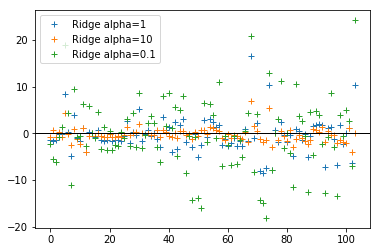

In [10]:
from sklearn.linear_model import Ridge
for a in [1, 10, 0.1]:
    ridge = Ridge(alpha=a).fit(X_train, y_train)
    print(f"alpha={a}")
    print(f"Training set score: {ridge.score(X_train, y_train)}")
    print(f"Test set score: {ridge.score(X_test, y_test)}")
    
    plt.plot(ridge.coef_, "+", label=f"Ridge alpha={a}")

plt.axhline(0, c="black", lw=1)
plt.legend()

# 3. Lasso (線形モデル)
リッジ回帰ではパラメータ全体を0に近付けたが、正則化には他に一部のパラメータを切り捨てる (一部パラメータを完全な0にする) 方法もある。これは **Lasso** と呼ばれる。実用上では最初にリッジ回帰を試すほうが良い。重要なパラメータが少ないと考えられる場合にはLassoが向いている。また、L1, L2両方を使えるElasticNetの方が性能では最良となる。しかし、2パラメータの調整が生じる。

## 特徴

* パラメータの数が減るため、モデルの解釈がしやすい

alpha=1
Training set score: 0.29323768991114607
Test set score: 0.20937503255272316
alpha=0.01
Training set score: 0.8962226511086498
Test set score: 0.7656571174549984
alpha=0.0001
Training set score: 0.950715875451546
Test set score: 0.6437467421273821


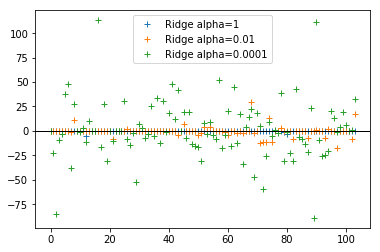

In [11]:
from sklearn.linear_model import Lasso

# 正則化の強さとパラメータの関係を描画
for a in [1, 0.01, 0.0001]:
    lasso = Lasso(alpha=a, max_iter=100000).fit(X_train, y_train)
    print(f"alpha={a}")
    print(f"Training set score: {lasso.score(X_train, y_train)}")
    print(f"Test set score: {lasso.score(X_test, y_test)}")
    
    plt.plot(lasso.coef_, "+", label=f"Ridge alpha={a}")

plt.axhline(0, c="black", lw=1)
plt.legend()

# 4. ロジスティック回帰 / 線形SVM (線形モデル)
分類に使われる。ロジスティック回帰も線形モデル同様、特徴量の多いデータに対しては過学習への対策が必要となる。

C=1
Training set score: 0.960093896713615
Test set score: 0.965034965034965
C=100
Training set score: 0.9765258215962441
Test set score: 0.965034965034965
C=0.001
Training set score: 0.9366197183098591
Test set score: 0.9790209790209791


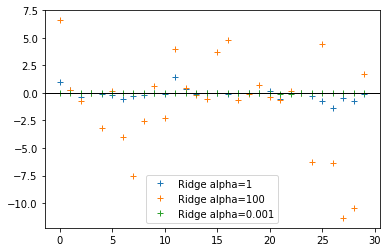

In [12]:
from sklearn.linear_model import LogisticRegression

# 学習器を初期化
cancer = datasets.load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=42)
logreg = LogisticRegression(solver="lbfgs", max_iter=10000).fit(X_train, y_train)

# 正則化の強さとパラメータの関係を描画
for c in [1, 100, 0.001]:
    logreg = LogisticRegression(C=c, solver="lbfgs", max_iter=10000).fit(X_train, y_train)
    plt.plot(logreg.coef_.reshape(-1), "+", label=f"Ridge alpha={c}")    
    print(f"C={c}")
    print(f"Training set score: {logreg.score(X_train, y_train)}")
    print(f"Test set score: {logreg.score(X_test, y_test)}")
    
plt.axhline(0, c="black", lw=1)
plt.legend()

多くのクラス分類モデルは2クラス分類しかできない。他クラス分類を行う場合、多くのモデルではクラス毎に学習器を作成し推論時には最も高い確率を出したクラスを推論結果としている (1対その他、one-vs.-rest)。

(3, 2)
(3,)


(-15, 15)

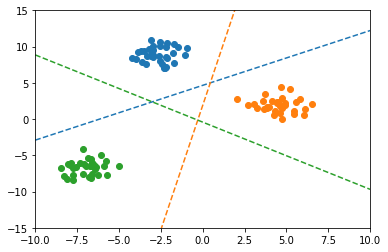

In [13]:
from sklearn.svm import LinearSVC

# 3クラスタを持つサンプルデータを生成
X, y = datasets.make_blobs(centers=3, random_state=42)

# 学習器
linear_svm = LinearSVC().fit(X, y)
print(linear_svm.coef_.shape)
print(linear_svm.intercept_.shape)

# 決定境界
x1 = np.linspace(-10, 10)
x2 = -(x1[:,np.newaxis] * linear_svm.coef_[:,0] + linear_svm.intercept_) / linear_svm.coef_[:,1]
for i in range(3):
    plt.scatter(*X[y == i].T)
    plt.plot(x1, x2[:,i], ls="--")

plt.xlim(-10, 10)
plt.ylim(-15, 15)    

# ナイーブベイズクラス分類機
3種類が使用可能。

* GaussianNB: 連続値に適用可能
* BernoulliBN: 2値データを仮定
* MultinomiaNB: カウントデータを仮定

## 特徴

* 線形モデルよりも更に高速
* 汎化性能はLogisticRegression, LinearSVCよりもわずかに劣る場合が多い

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

nb = GaussianNB().fit(X_train, y_train)
print(nb.score(X_train, y_train))
print(nb.score(X_test, y_test))

0.9366197183098591
0.958041958041958


# 决定木

2値の質問の樹形図によって学習する手法。1つの質問は1つの特徴量しか考えないため、分割された領域は常に軸に平行な境界を持つ。1つのデータポイントしか持たない决定木の葉の状態のことは **純粋** と呼ばれる。純粋はモデルとしては過学習の疑いがある。モデルの複雑さを制御する方法に **事前枝刈り** 、 **事後枝刈り** があり、scikit-learn では事前枝刈りを使用可能。

scikit-learnでは次の学習器が使用可能

* DecisionTreeClassifier
* DecisionTreeRegressor

## 特徴

* メリット
    * 結果モデルの可視化が容易
    * 小さい决定木ならば非専門家でも理解が容易
    * 特徴量の正規化や標準化が不要 (データのスケールや連続・非連続が影響しない)
    * 外挿は出来ないため、訓練データの範囲の外側は予測できない
* デメリット
    * 過学習しやすい

## パラメータ
* max_depth  
  事前枝刈りとして决定木を構築する最大階層数を指定する。小さいほど制約が強くなる。

## メトリクス
* feature_importances_  
  特徴量毎の重要度。合計1で0～1の実数が入っている。
* export_graphviz(tree)  
  决定木をdot形式の文字列として返す。graphvizなどで可視化するのに使う

In [15]:
def dot2svg(dotsrc: str):
    """决定木を可視化
    """
    
    import pydotplus
    from IPython.display import SVG

    dt = pydotplus.graph_from_dot_data(dotsrc)
    sv = SVG(dt.create_svg())
    return sv

Accuracy on training set: 1.000
Accuracy on test set: 0.937


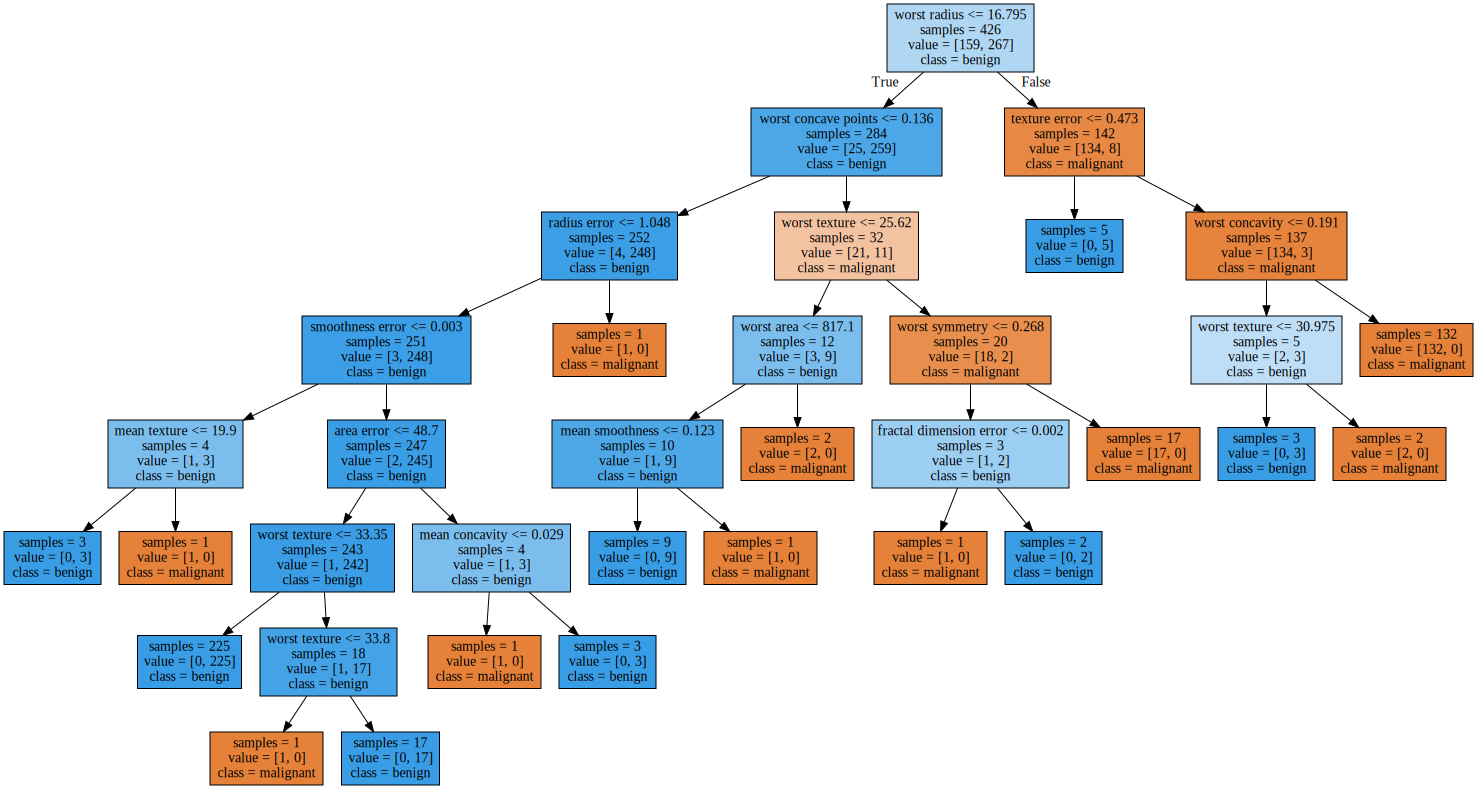

In [16]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

# 学習器を初期化
cancer = datasets.load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

# 評価
print(f"Accuracy on training set: {tree.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {tree.score(X_test, y_test):.3f}")
dot2svg(export_graphviz(
    tree, class_names=cancer.target_names, feature_names=cancer.feature_names, impurity=False, filled=True))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


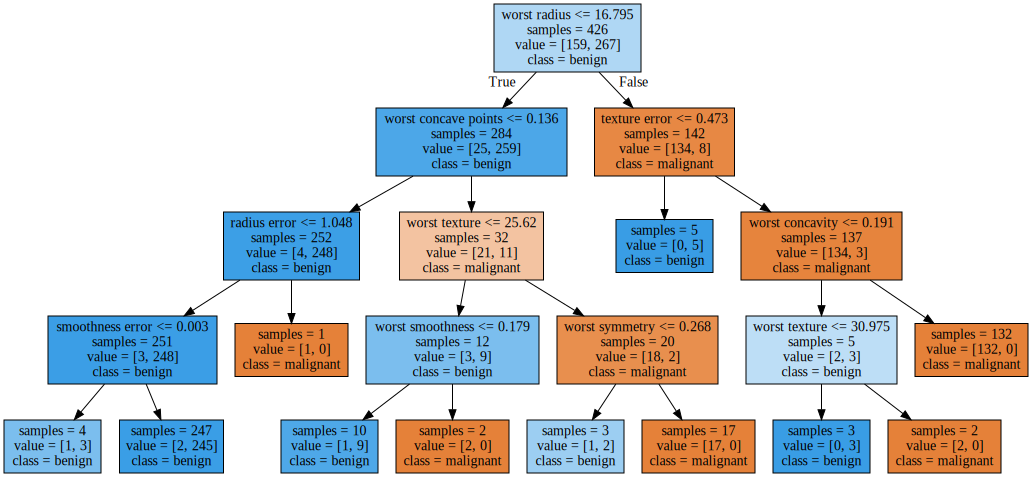

In [17]:
# 学習器を初期化 (事前枝刈りとして最大階層を4までに制約)
tree = DecisionTreeClassifier(max_depth=4, random_state=0).fit(X_train, y_train)

# 評価
print(f"Accuracy on training set: {tree.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {tree.score(X_test, y_test):.3f}")
dot2svg(export_graphviz(
    tree, class_names=cancer.target_names, feature_names=cancer.feature_names, impurity=False, filled=True))

决定木を検証する良い方法の1つとして、大多数のデータが辿るパスを見つける方法がある。上記の决定木の場合、ルートから右の枝 (worst radius > 16.795) は142の悪性と8の良性しかなく、殆どは一番右 (worst concavity <= 0.191のFalse側) に分類されており、残りの决定木は残り8つの良性を識別するために費やされている。ルートから左の枝は25の悪性と259の良性があり、殆どの良性は左から2番目に行き着く事がわかる。

## パラメータ毎の重要度
tree.feature_importances_ に各特徴量の重要度が格納されており、0～1の実数(0: まったく使えない、1: 完全に予測できる)になっている。実数の合計は1になる。しかし、**重要度が低い → 情報が少ないとは限らない** (別の特徴量に同じ情報がエンコードされており、偶然决定木に採用されないことはある)。

Text(0.5, 0, 'Feature importance')

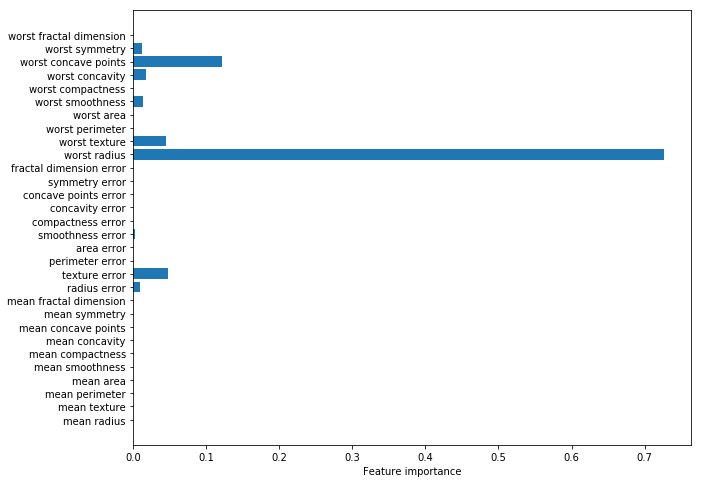

In [18]:
n_features = range(tree.feature_importances_.size)
plt.figure(figsize=(10, 8))
plt.barh(n_features, tree.feature_importances_)
plt.yticks(n_features, cancer.feature_names)
plt.xlabel("Feature importance")

# ランダムフォレスト
决定木の問題は過学習しやすいことにある。複数の機械学習モデルを組み合わせることでより強力なモデルを構築する方法がある (アンサンブル法)。

さまざまなデータセットに対するクラス分類や回帰に有効であることがわかっている方法としてランダムフォレストと勾配ブースティング决定木がある。ランダムフォレストは、决定木は一部のデータに対して過剰適合してしまうという考えの下、少しずつ異なる决定木をたくさん集めて多数決を取ることで過学習に対する問題を解決する。

## 特徴

* 性能が高く、またパラメータのチューニングが雑でもよく機能する
* 実行時間やメモリが重要なタスクには不向き (線形モデルよりは訓練・学習は遅く、メモリも消費する)
    * 並列化自体は容易で、n_jobs にスレッド数を指定で高速化
* モデルが本質的にランダムで再現性はない (再現性が必要ならば random_sateにシード値を指定)
* 疎なデータセットには弱い

## パラメータ

* n_estimators  
  学習器の数。多いほど性能が上がる。時間とメモリのある限り大きくする
* max_features  
  学習器1つあたりの使用する特徴量の数。大きいほど単一の决定木と近くなり、過剰適合するようになる
* max_depth  
  学習の枝の深さを指定。多いほど過剰適合する。既定値で良い

Accuracy on training set: 0.987
Accuracy on test set: 0.880


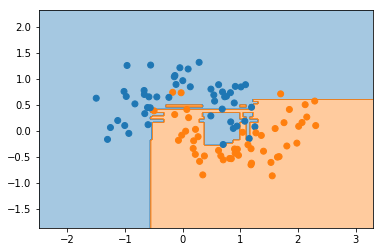

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from matplotlib.colors import ListedColormap

def plot_class_separator(estimator, X, y):
    """决定境界を描画
    """
    
    X_min, X_max = np.min(X, axis=0), np.max(X, axis=0)
    
    # メッシュ状にデータ生成
    xn = 200
    x0 = np.linspace(X_min[0] - 1, X_max[0] + 1, xn)
    x1 = np.linspace(X_min[1] - 1, X_max[1] + 1, xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    xx0, xx1 = xx0.reshape(-1), xx1.reshape(-1)

    # 生成データを分類
    xx = np.c_[xx0, xx1]
    yy = estimator.predict(xx)

    # 决定境界を描画
    xx0 = xx[:,0].reshape(xn, xn)
    xx1 = xx[:,1].reshape(xn, xn)
    yy = yy.reshape(xn, xn)
    cmap = ListedColormap(plt.cm.tab10.colors[:2])
    plt.contourf(xx0, xx1, yy, cmap=cmap, alpha=0.4)
    return plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap)

# データ生成
X, y = make_moons(n_samples=100, noise=0.25, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# クラス分類
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)
print(f"Accuracy on training set: {forest.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {forest.score(X_test, y_test):.3f}")

# 决定境界を描画
plot_class_separator(forest, X, y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# cancerで学習させてみる
forest = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)

# ハイパーパラメータ未調整で 正答率97.2% の精度が出る。
print(f"Accuracy on training set: {forest.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {forest.score(X_test, y_test):.3f}")

Accuracy on training set: 1.000
Accuracy on test set: 0.972


Text(0.5, 0, 'Feature importance')

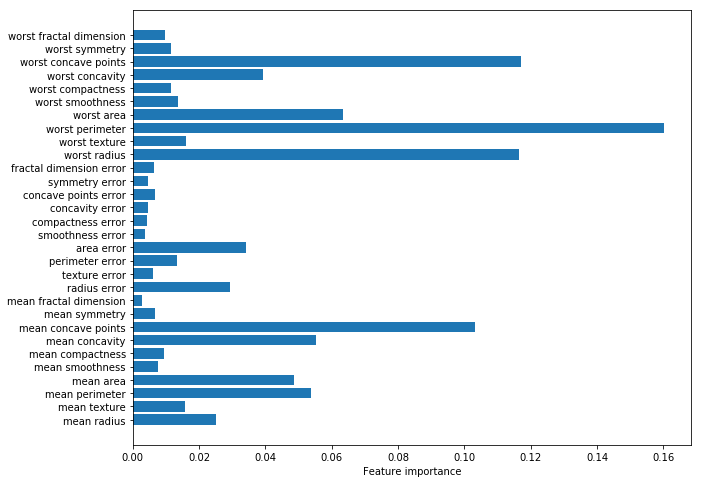

In [21]:
n_features = range(tree.feature_importances_.size)
plt.figure(figsize=(10, 8))
plt.barh(n_features, forest.feature_importances_)
plt.yticks(n_features, cancer.feature_names)
plt.xlabel("Feature importance")

# 勾配ブースティング回帰木
別名: 勾配ブースティングマシン。ランダムフォレストの様にランダムな决定木は作らず、1つ前の决定木の誤りを次の决定木が修正するようにして决定木を生成する手法。強力な事前枝刈りを行うため、各决定木は深さが1～5くらいの浅いものになる。ランダムフォレストと比較し、パラメータ設定に対して敏感だが、適切に設定されればこちらの方が性能が良い。

## 特徴
* パラメータには敏感。最新の注意が必要
* 訓練時間が長い
* 决定木と同じく、2値特徴量と連続特徴量の混在や特徴量のスケールには強く、疎データには弱い

## パラメータ
時間とメモリで n_estimator を決め、 learning_rate で複雑度を調整する事が多い。

* n_estimator  
  学習器の数を設定。多いほど複雑なモデルになる
* max_depth  
  事前枝刈り。决定木の深さの最大値を指定
* learning_rate  
  学習率と呼ばれる。大きい程に前の决定木の誤りを強く補正しようとするため、モデルが複雑になる

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# 学習
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

# 評価
print(f"Accuracy on training set: {gbrt.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {gbrt.score(X_test, y_test):.3f}")

Accuracy on training set: 1.000
Accuracy on test set: 0.958


In [23]:
# 学習 (决定木の最大階層を1にする)
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

# 評価
print(f"Accuracy on training set: {gbrt.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {gbrt.score(X_test, y_test):.3f}")

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [24]:
# 学習 (学習率を小さくする)
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

# 評価
print(f"Accuracy on training set: {gbrt.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {gbrt.score(X_test, y_test):.3f}")

Accuracy on training set: 0.988
Accuracy on test set: 0.965


# カーネル法を用いたサポートベクタマシン

線形モデルは特徴量を非線形関数へ通して追加すると表現力を更に上げられる。これは混じり合った2次元の多クラスデータならば次元を追加し、3軸目で分かれるようなマッピングを起こすといった事をしている。高次元空間へのマッピングは方法によっては計算量が大きいが、現実的速度で行う方法として **カーネルトリック** がある。

高次元空間へのマッピング方法には、特定の次数までの全ての多項式を計算する多項式カーネルと、ガウシアンカーネル(別名: RBF, 放射基底関数カーネル)がある。ガウシアンカーネルは無限次元の特徴空間に対応している。

## 特徴

* 特徴量の数が少ない場合にも複雑な决定境界を生成可能
* サンプル数が多いと重い (10,000サンプルが目安)
* 注意深くデータの前処理 (特徴量のスケールを揃える必要がある) とパラメータ調整が必要
* 訓練結果の検証や予測の理由の理解が難しい

## パラメータ

* gamma  
  ガウシアンカーネルの幅 (点との距離が近いとするスケール) を調整する。大きい程に高次元空間上での起伏が激しくなる
* C  
  重みパラメータへのL2正則化の強さを指定する。大きい程に决定境界の非線形性が強くなる
* kernel
  使用するカーネル

SVMはスケールに敏感だが、cancerのデータセットは特徴量でスケールが異なる。

Accuracy on training set: 0.995
Accuracy on test set: 0.965


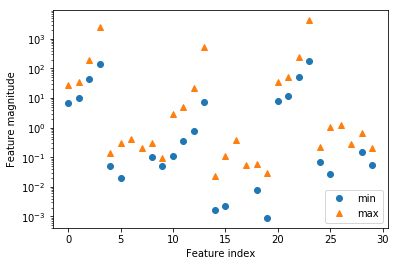

In [25]:
from sklearn.svm import SVC
from sklearn.preprocessing import  MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

plt.plot(X_train.min(axis=0), "o", label="min")
plt.plot(X_train.max(axis=0), "^", label="max")
plt.legend(loc=4)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")
plt.yscale("log")

# スケールを0～1に変換
mms = MinMaxScaler()
mms.fit(X_train)
X_train = mms.transform(X_train)
X_test = mms.transform(X_test)

svc = SVC(C=1000, gamma="scale")
svc.fit(X_train, y_train)
print(f"Accuracy on training set: {svc.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {svc.score(X_test, y_test):.3f}")

# ニューラルネットワーク

## 特徴

* 非常に複雑なモデルを構築可能
* 大きなネットワークは訓練に時間がかかる
* 入力特徴量のスケールは統一する必要がある (平均: 0、分散: 1 が理想)
* 重みパラメータの初期値が乱数。小さいネットワークで学習のばらつきに注意

## パラメータ
隠れ層の数とユニット数が重要になる。隠れ層の数は1か2で初め、後から増やすのが良い。ユニット数は入力層と同じ数を指定する事が多い。しかし、数千より大きくなることはあまりない。調整は過学習するよう大きいネットワークを作成し、訓練データの学習ができることを確認してからネットワークを小さくするか正則化を強化することが多い。

* solver  
  オプティマイザを指定。"adam"が既定 (よく機能するが、データのスケールに敏感。平均0、分散1が大切)。"lbfgs"はスケールに頑強だが、データサイズが大きい場合に時間がかかる。他に"sgd"もあるが、パラメータの数が多い。
* hidden_layer_sizes  
  隠れ層のユニット数。層ごとのユニット数をリストとして渡す。層やユニットの数が多ければ多いほどモデルの複雑さは上がる
* alpha  
  重みパラメータへ掛けるL2正則化の強さ。大きい程、モデルの複雑さは下がる
* activation  
  活性化関数。"relu"や"tanh"を指定

Accuracy on training set: 1.000
Accuracy on test set: 0.880


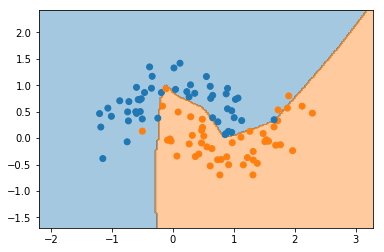

In [26]:
from sklearn.neural_network import MLPClassifier

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

mlp = MLPClassifier(solver="lbfgs", random_state=0, hidden_layer_sizes=[100]).fit(X_train, y_train)
plot_class_separator(mlp, X, y)
print(f"Accuracy on training set: {mlp.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {mlp.score(X_test, y_test):.3f}")

In [27]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# スケール調整
mms = MinMaxScaler()
mms.fit(X_train)
X_train = mms.transform(X_train)
X_test = mms.transform(X_test)


mlp = MLPClassifier(max_iter=1000, random_state=0, hidden_layer_sizes=[100], alpha=1).fit(X_train, y_train)
print(f"Accuracy on training set: {mlp.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {mlp.score(X_test, y_test):.3f}")

Accuracy on training set: 0.979
Accuracy on test set: 0.958


入力層と1番目の隠れ層の間の重みパラメータを可視化。縦に入力側、横に隠れ側の組合せでパラメータが格納される。横方向に薄い帯がある場合にはその特徴量の重要度が低いか、学習器が扱える表現になっていなかった事が想定される。隠れ層の重みパラメータ可視化も可能だが、入力層以上に解釈が難しくなる。

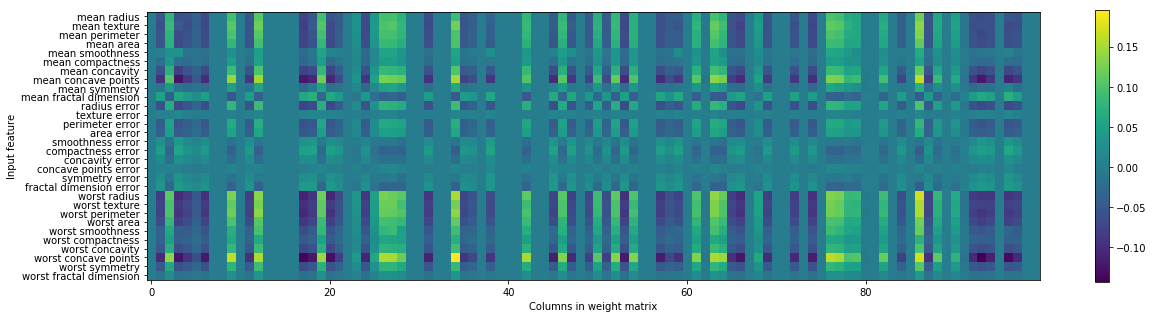

In [28]:
plt.figure(figsize=(20, 5))
plt.imshow(mlp.coefs_[0], interpolation="none", cmap="viridis")
plt.yticks(range(30), cancer.feature_names)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()

# 不確実性推定
クラス分類機の予測に対する不確実性推定機能というものがある。あるテストポイントに対して、クラス分類機の予測がどれくらい確かなのかを調べられる。確度は過学習のモデルでは間違っていても高い数値が出る。モデルが出す確度と実際の正答率が一致する場合、 **較正されている** と呼ばれる。

## 决定関数
0基準で絶対値が大きい程確信度が高い。スケールはデータに拠る

## 確率予測
分類ごとの確度を確率として求める (全クラスの確率の合計は1になる)。

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
gbrt = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)

# 正答率
print(gbrt.score(X_test, y_test))

# 决定関数
print(gbrt.decision_function(X_test))

# 確率予測
print(gbrt.predict_proba(X_test[:5]))

0.84
[ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106
 -7.69097177  4.11001634  1.10753883  3.40782247 -6.46262729  4.28986668
  3.90156371 -1.20031192  3.66166106 -4.17231209 -1.23010022 -3.91576275
  4.03602808  4.11001634  4.11001634  0.65708962  2.69826291 -2.65673325
 -1.86776597]
[[0.01573626 0.98426374]
 [0.84575649 0.15424351]
 [0.98112869 0.01887131]
 [0.97406775 0.02593225]
 [0.01352142 0.98647858]]


# 学習器まとめ
新しいデータセットを扱う場合、線形モデルやナイーブベイズや最近傍法などの簡単なモデルでどれくらいの精度が得られるか試すと良い。データをより理解できたらより複雑なモデルへ移行を考えると良い。

* 最近傍法  
  小さいデータに関しては良いベースラインになる
* 線形モデル  
  最初に試してみるべきアルゴリズム。非常に大きいデータセットや高次元のデータに適する。
* ナイーブベイズ  
  クラス分類にのみ使用可能。線形モデルよりさらに巨大または高次元のデータに向く。高速だが精度は線形モデルより劣る
* 决定木  
  非常に高速。データのスケール考慮が不要。可視化可能で説明しやすい
* ランダムフォレスト  
  データのスケールを考慮する必要はない。决定木よりも高速・頑健・強力だが、高次元の疎データには適さない
* 勾配ブースティング决定木  
  ランダムフォレストと比較し、訓練は長くなるが精度は少し高く、メモリ使用量も少ない。パラメータには敏感
* サポートベクターマシン  
  同じような意味を持つ特徴量からなる中規模なデータセットに対して強力。データスケールの統一が必要。パラメータには敏感
* ニューラルネットワーク  
  非常に複雑なモデルを構築可能。大きなデータセットに有効だが、データスケールの統一が必要な他、パラメータには敏感。訓練に時間がかかる。